# Data visualization around the Grenoble 2020 elections - followers & friends

## Loading the data

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
    'CommuneEstANous': 'La commune est à nous !',
}
names = {
    'EricPiolle': 'Éric Piolle',
    'EmilieCChalas': 'Emilie Chalas',
    'CarignonAlain': 'Alain Carignon',
    'onoblecourt': 'Olivier Noblecourt',
    'Grenoble_Commun': 'Grenoble en Commun',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
    'CommuneEstANous': 'La commune est à nous !',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',
    'La commune est à nous !': '#bb0000'
}
colors2 = {names[n]: colors[users[n]] for n in names}

In [3]:
follower_files = [
    'followers/CarignonAlain.csv',
    'followers/EmilieCChalas.csv',
    'followers/onoblecourt.csv',
    'followers/EricPiolle.csv',
]

friend_files = [
    'friends/CarignonAlain.csv',
    'friends/EmilieCChalas.csv',
    'friends/onoblecourt.csv',
    'friends/EricPiolle.csv',
]

follower_files = [
    'followers_lists/Grenoble_Commun.csv',
    'followers_lists/GrenobleNvAir.csv',
    'followers_lists/Chalas2020.csv',
    'followers_lists/CommuneEstANous.csv',
]

friend_files = [
    'friends_lists/Grenoble_Commun.csv',
    'friends_lists/GrenobleNvAir.csv',
    'friends_lists/Chalas2020.csv',
    'friends_lists/CommuneEstANous.csv',
]

filenames = follower_files + friend_files

data = []
for f in filenames:
    login = f.split('/')[1].split('.')[0]
    relation = 'followers' if 'follower' in f else 'friends'
    tmp = pandas.read_csv(f)
    tmp['relation'] = relation
    tmp['candidate_login'] = login
    tmp['candidate_name'] = names[login]
    tmp['candidate_tag'] = users[login]
    data.append(tmp)
df = pandas.concat(data)
df['date'] = pandas.to_datetime(df['date'])

print(len(df), len(df.columns))

3048 19


In [4]:
df.groupby('candidate_name')[['date']].agg(['min', 'max', 'count'])

date                          
                                               min                 max count
candidate_name                                                              
Grenoble Nouvel Air            2007-03-05 22:08:25 2020-02-24 09:12:58   616
Grenoble en Commun             2007-03-28 12:14:38 2020-02-28 19:58:25  1561
La commune est à nous !        2007-09-03 17:11:53 2020-02-24 09:12:58   439
Un Nouveau Regard sur Grenoble 2008-12-06 16:59:14 2020-02-28 14:48:49   432

## Followers sharing

In [5]:
def compute_sharing_matrix(df):
    tmp = []
    for c1 in df['candidate_name'].unique():
        for c2 in df['candidate_name'].unique():
            nb = len(set(df[df['candidate_name'] == c1]['id']) & set(df[df['candidate_name'] == c2]['id']))
            total = len(df[df['candidate_name'] == c1])
            percent = nb/total * 100
            txt_a = f'{percent:.1f}%' if percent < 100 else ''
            txt_b = f'{nb}/{total}' if percent < 100 else ''
            txt = f'{txt_b}\n{txt_a}'
            if c1 == c2:
                nb = 0
                percent = 0
            tmp.append({
                'candidate': c1,
                'other': c2,
                'nb_common': nb,
                'percent_shared': percent,
                'text': txt
            })
    return pandas.DataFrame(tmp)
shared_followers = compute_sharing_matrix(df[df['relation'] == 'followers'])
shared_followers

,candidate,other,nb_common,percent_shared,text
0,Grenoble en Commun,Grenoble en Commun,0,0.000000,\n
1,Grenoble en Commun,Grenoble Nouvel Air,185,16.864175,185/1097\n16.9%
2,Grenoble en Commun,Un Nouveau Regard sur Grenoble,144,13.126709,144/1097\n13.1%
3,Grenoble en Commun,La commune est à nous !,92,8.386509,92/1097\n8.4%
4,Grenoble Nouvel Air,Grenoble en Commun,185,49.597855,185/373\n49.6%
5,Grenoble Nouvel Air,Grenoble Nouvel Air,0,0.000000,\n
6,Grenoble Nouvel Air,Un Nouveau Regard sur Grenoble,152,40.750670,152/373\n40.8%
7,Grenoble Nouvel Air,La commune est à nous !,77,20.643432,77/373\n20.6%
8,Un Nouveau Regard sur Grenoble,Grenoble en Commun,144,38.095238,144/378\n38.1%
9,Un Nouveau Regard sur Grenoble,Grenoble Nouvel Air,152,40.211640,152/378\n40.2%


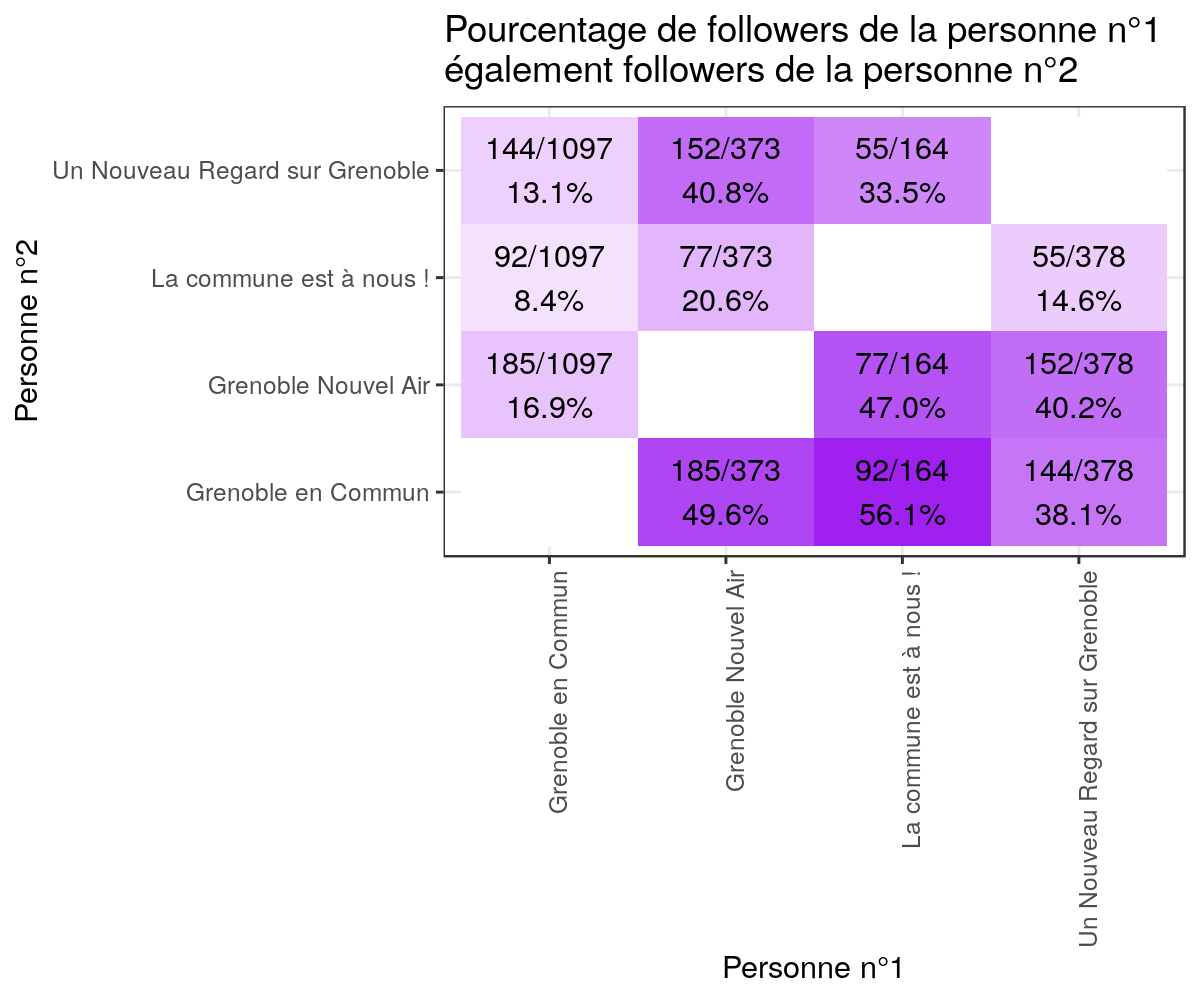

In [6]:
%%R -i shared_followers -w 6 -h 5 --units in -r 200

library(ggplot2)

plot = ggplot(shared_followers) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle('Pourcentage de followers de la personne n°1\négalement followers de la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

## Shared friends

In [7]:
shared_friends = compute_sharing_matrix(df[df['relation'] == 'friends'])
shared_friends

,candidate,other,nb_common,percent_shared,text
0,Grenoble en Commun,Grenoble en Commun,0,0.000000,\n
1,Grenoble en Commun,Grenoble Nouvel Air,83,17.887931,83/464\n17.9%
2,Grenoble en Commun,Un Nouveau Regard sur Grenoble,10,2.155172,10/464\n2.2%
3,Grenoble en Commun,La commune est à nous !,96,20.689655,96/464\n20.7%
4,Grenoble Nouvel Air,Grenoble en Commun,83,34.156379,83/243\n34.2%
5,Grenoble Nouvel Air,Grenoble Nouvel Air,0,0.000000,\n
6,Grenoble Nouvel Air,Un Nouveau Regard sur Grenoble,14,5.761317,14/243\n5.8%
7,Grenoble Nouvel Air,La commune est à nous !,67,27.572016,67/243\n27.6%
8,Un Nouveau Regard sur Grenoble,Grenoble en Commun,10,18.518519,10/54\n18.5%
9,Un Nouveau Regard sur Grenoble,Grenoble Nouvel Air,14,25.925926,14/54\n25.9%


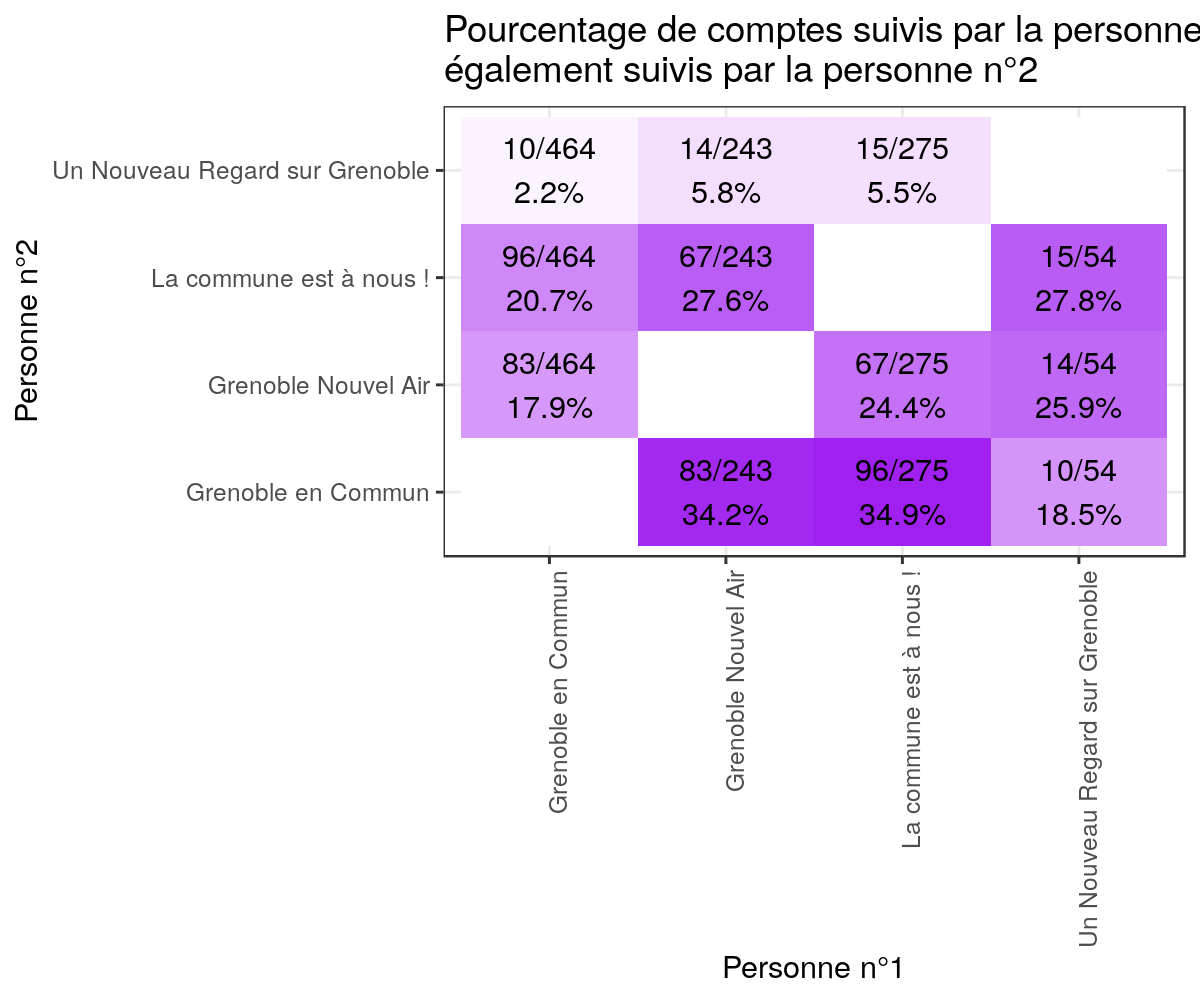

In [8]:
%%R -i shared_friends -w 6 -h 5 --units in -r 200

library(ggplot2)

plot = ggplot(shared_friends) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle('Pourcentage de comptes suivis par la personne n°1\négalement suivis par la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

## Localisation

In [9]:
import re

def count_locations(df, locations):
    df = df.copy()
    df.loc[df['location'].isna(), 'location'] = 'no_location'
    result = []
    for login in df['candidate_login'].unique():
        tmp = df[df['candidate_login'] == login]
        for loc in locations:
            loc = '|'.join(loc)
            nb_loc = len(tmp['location'].str.extractall(r'(?P<ville>%s)' % loc, re.IGNORECASE))
            nb_total = len(tmp)
            result.append({
                'login': login,
                'name': names[login],
                'tag': users[login],
                'location': loc,
                'count': nb_loc,
                'percent': nb_loc/nb_total*100,
            })
    result = pandas.DataFrame(result)
    return result


def count_locations_fr(df):
    locations = count_locations(df, [['Grenoble'], ['Paris']])
    others = count_locations(df, [['Nantes', 'Rennes', 'Bordeaux', 'Strasbourg', 'Toulouse', 'Marseille', 'Montpellier', 'Nice', 'Lyon']])
    others['location'] = 'Autres grandes villes FR'
    noloc = count_locations(df, [['no_location']])
    noloc['location'] = 'Non spécifiée'
    locations = pandas.concat([locations, others, noloc])
    return locations

locations = count_locations_fr(df[df['relation'] == 'followers'])
locations

,login,name,tag,location,count,percent
0,Grenoble_Commun,Grenoble en Commun,Grenoble en Commun,Grenoble,360,32.816773
1,Grenoble_Commun,Grenoble en Commun,Grenoble en Commun,Paris,67,6.107566
2,GrenobleNvAir,Grenoble Nouvel Air,Grenoble Nouvel Air,Grenoble,173,46.380697
3,GrenobleNvAir,Grenoble Nouvel Air,Grenoble Nouvel Air,Paris,16,4.289544
4,Chalas2020,Un Nouveau Regard sur Grenoble,Un Nouveau Regard sur Grenoble,Grenoble,141,37.301587
5,Chalas2020,Un Nouveau Regard sur Grenoble,Un Nouveau Regard sur Grenoble,Paris,23,6.084656
6,CommuneEstANous,La commune est à nous !,La commune est à nous !,Grenoble,87,53.048780
7,CommuneEstANous,La commune est à nous !,La commune est à nous !,Paris,10,6.097561
0,Grenoble_Commun,Grenoble en Commun,Grenoble en Commun,Autres grandes villes FR,47,4.284412
1,GrenobleNvAir,Grenoble Nouvel Air,Grenoble Nouvel Air,Autres grandes villes FR,10,2.680965


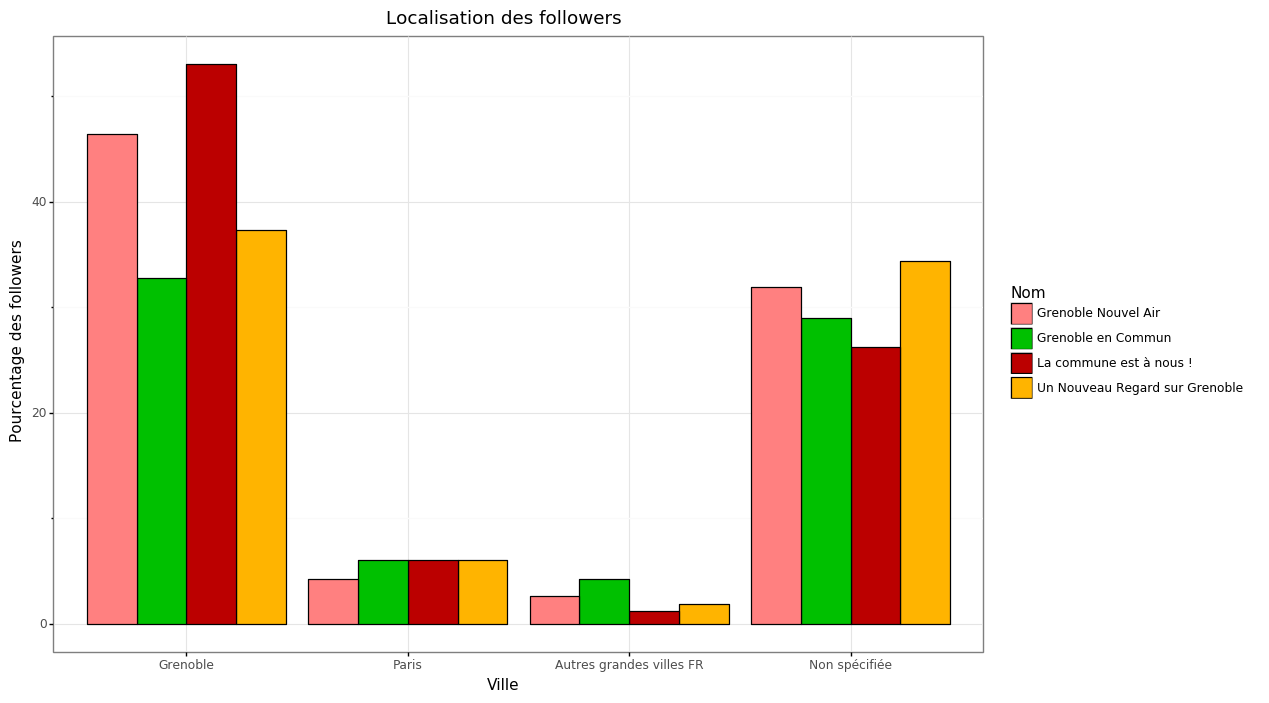

<ggplot: (8746311851994)>

In [10]:
ggplot(locations) +\
    aes(x='location', y='percent', group='name') +\
    geom_bar(aes(fill='name', group='name'), stat='identity', color='black', position='dodge') +\
    theme_bw() +\
    scale_fill_manual(colors2) +\
    ylab('Pourcentage des followers') +\
    xlab('Ville') +\
    labs(fill='Nom') +\
    scale_x_discrete(limits=['Grenoble', 'Paris', 'Autres grandes villes FR', 'Non spécifiée']) +\
    ggtitle('Localisation des followers')

## Mutual follows

In [11]:
followers = df[df['relation'] == 'followers'].set_index(['screen_name', 'candidate_login'])
friends = df[df['relation'] == 'friends'].set_index(['screen_name', 'candidate_login'])
mutuals = followers.join(friends, how='inner', rsuffix='_').reset_index()
print(len(followers))
print(len(friends))
print(len(mutuals))

2012
1036
520


In [12]:
shared_mutuals = compute_sharing_matrix(mutuals)
shared_mutuals

,candidate,other,nb_common,percent_shared,text
0,Grenoble Nouvel Air,Grenoble Nouvel Air,0,0.000000,\n
1,Grenoble Nouvel Air,Grenoble en Commun,14,20.289855,14/69\n20.3%
2,Grenoble Nouvel Air,La commune est à nous !,22,31.884058,22/69\n31.9%
3,Grenoble Nouvel Air,Un Nouveau Regard sur Grenoble,7,10.144928,7/69\n10.1%
4,Grenoble en Commun,Grenoble Nouvel Air,14,5.533597,14/253\n5.5%
5,Grenoble en Commun,Grenoble en Commun,0,0.000000,\n
6,Grenoble en Commun,La commune est à nous !,42,16.600791,42/253\n16.6%
7,Grenoble en Commun,Un Nouveau Regard sur Grenoble,5,1.976285,5/253\n2.0%
8,La commune est à nous !,Grenoble Nouvel Air,22,13.836478,22/159\n13.8%
9,La commune est à nous !,Grenoble en Commun,42,26.415094,42/159\n26.4%


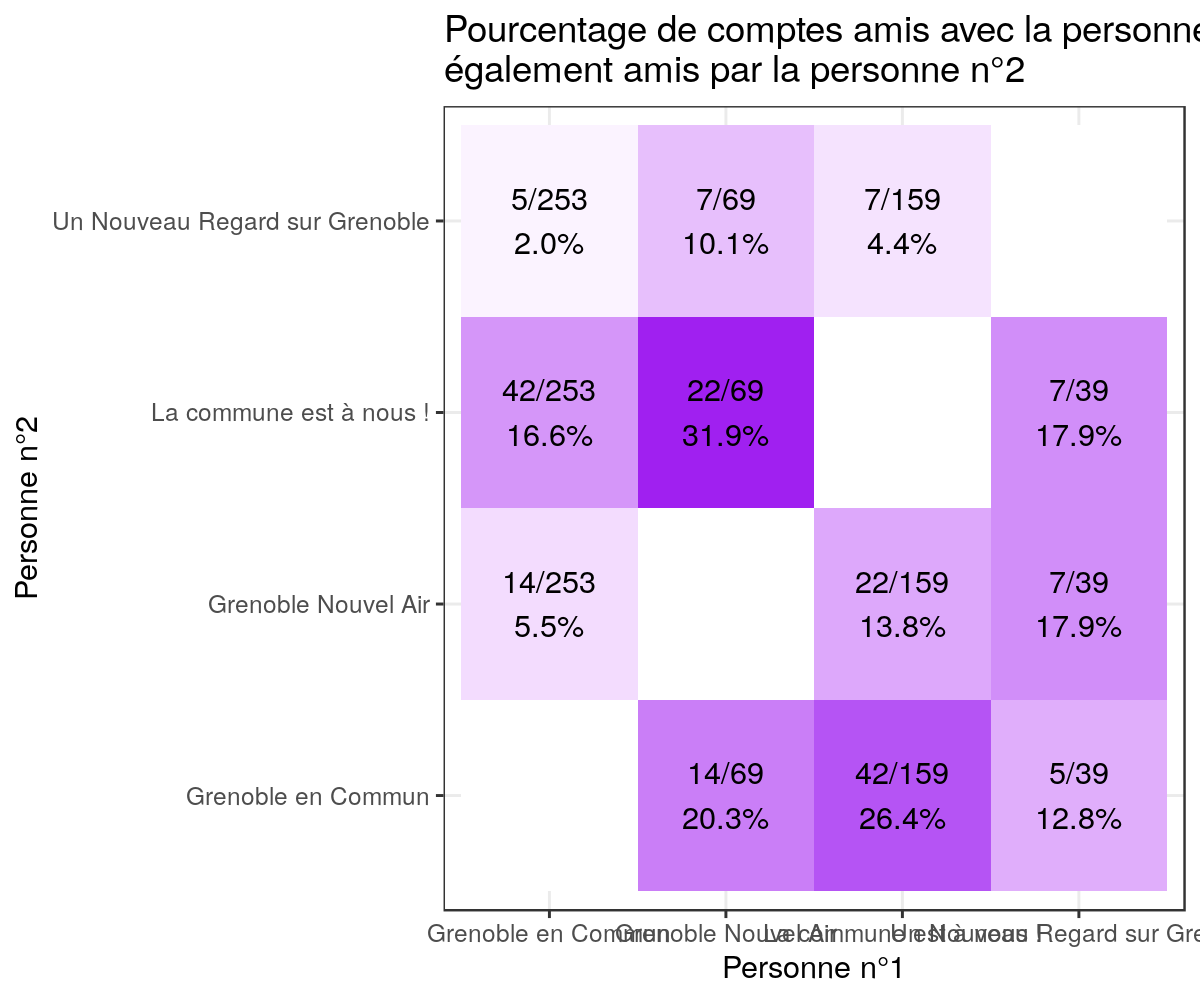

In [13]:
%%R -i shared_mutuals -w 6 -h 5 --units in -r 200

plot = ggplot(shared_mutuals) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    ggtitle('Pourcentage de comptes amis avec la personne n°1\négalement amis par la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

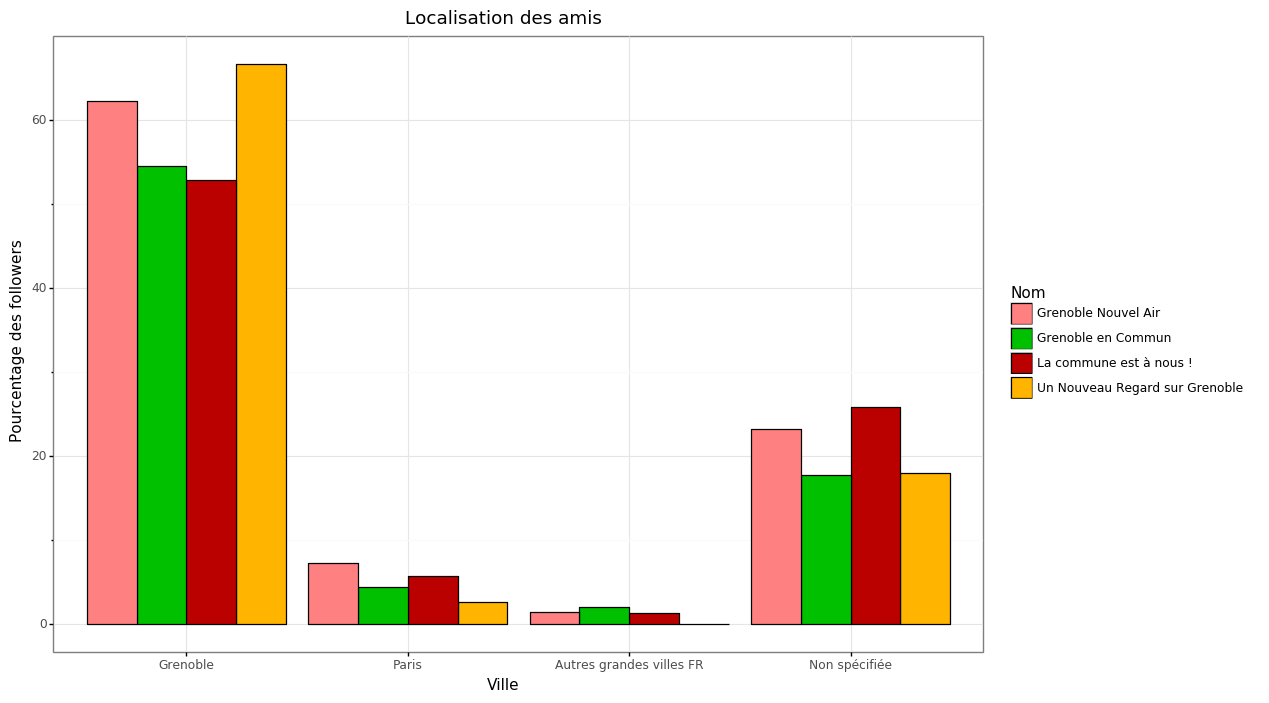

<ggplot: (-9223363290598256496)>

In [14]:
locations = count_locations_fr(mutuals)
ggplot(locations) +\
    aes(x='location', y='percent', group='name') +\
    geom_bar(aes(fill='name', group='name'), stat='identity', color='black', position='dodge') +\
    theme_bw() +\
    scale_fill_manual(colors2) +\
    ylab('Pourcentage des followers') +\
    xlab('Ville') +\
    labs(fill='Nom') +\
    scale_x_discrete(limits=['Grenoble', 'Paris', 'Autres grandes villes FR', 'Non spécifiée']) +\
    ggtitle('Localisation des amis')